In [62]:
import os 

# 가상 환경에서 발생하는 라이브러리 중복 로드 문제 해결
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [63]:
# 기본 라이브러리 및 PyTorch 관련 모듈 불러오기
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [64]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

In [65]:
# 메타데이터를 불러와 특정 배터리를 선택
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"

meta = pd.read_csv(META_PATH)

battery_id = "B0006"

# 선택한 배터리 id에 해당하는 discharge type 데이터 필터링 및 정렬
battery_meta = (
    meta[(meta["type"] == "discharge") & (meta["battery_id"] == battery_id)]
    .sort_values("start_time")
    .reset_index(drop=True)
)

# Capacity 열을 숫자형으로 변환하고 사이클 인덱스 및 soh 열 추가
battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
battery_meta["cycle_index"] = np.arange(len(battery_meta))
battery_meta["soh"] = battery_meta["Capacity"] / battery_meta["Capacity"].iloc[0]

display(battery_meta[["type", "cycle_index", "soh"]].head())
print(f"사이클 수: {len(battery_meta)}")

,type,cycle_index,soh
0,discharge,0,1.000000
1,discharge,1,1.057732
2,discharge,2,1.052433
3,discharge,3,0.964158
4,discharge,4,0.933925


사이클 수: 168


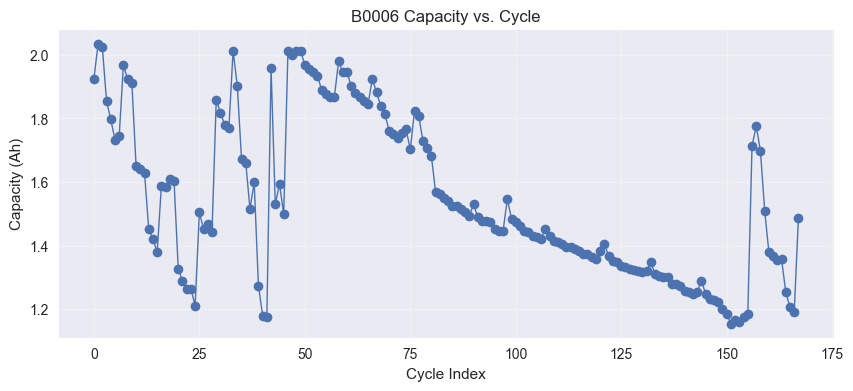

In [66]:
# 용량 감소 추이를 시각화하여 노화 패턴 확인
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(battery_meta["cycle_index"], battery_meta["Capacity"], marker="o", linewidth=1)
ax.set_xlabel("Cycle Index")
ax.set_ylabel("Capacity (Ah)")
ax.set_title(f"{battery_id} Capacity vs. Cycle")
ax.grid(True, alpha=0.3)
plt.show()

In [67]:
# 시계열 윈도우 기반 데이터셋 생성
WINDOW_SIZE = 3 # 과거 3개의 사이클 사용

FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

def create_sequence_windows(sequences, targets, window_size):
    """
    연속된 window_size개의 사이클로 다음 사이클의 SOH 예측 
    """
    X_windows = [] 
    y_windows = [] 
    for i in range(len(sequences) - window_size):
        # 과거 window_size개의 사이클의 시퀀스를 쌓음
        window = sequences[i:i+window_size] # (window_size, 120, 5)
        target = targets[i+window_size] # 다음 사이클의 SOH
        
        X_windows.append(window)
        y_windows.append(target)
        
    return np.array(X_windows), np.array(y_windows)

In [68]:
# 각 방전 사이클을 균일한 길이로 보간하는 함수 정의
SEQ_LEN = 179 # 최소 시퀀스 길이

def load_cycle_sequence(filename: str, seq_len: int = SEQ_LEN) -> np.ndarray:
    """
    원본 csv마다 측정 시간이 다르기 때문에 SEQ_LEN 길이로 리샘플링
    -> 고정 길이 텐서로 맞춰주기 위함
    """
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = []
    for col in FEATURE_COLS:
        interpolated.append(np.interp(new_time, time, df[col].values))
    return np.stack(interpolated, axis=1)

# 선택한 배터리의 모든 방전 사이클을 시퀀스로 변환
sequences = np.stack(
    [load_cycle_sequence(fn) for fn in battery_meta["filename"]], axis=0
)
targets = battery_meta["soh"].values

print(f"원본 시퀀스 데이터 형태: {sequences.shape}")  # (N, 120, 5)
print(f"원본 타겟 데이터 형태: {targets.shape}")      # (N,)

# 윈도우 방식으로 데이터 변환
X_windows, y_windows = create_sequence_windows(sequences, targets, WINDOW_SIZE)

print(f"\n윈도우 시퀀스 데이터 형태: {X_windows.shape}")  # (N-3, 3, 120, 5)
print(f"윈도우 타겟 데이터 형태: {y_windows.shape}")      # (N-3,)
print(f"사용 가능한 샘플 수: {len(X_windows)}")

원본 시퀀스 데이터 형태: (168, 179, 5)
원본 타겟 데이터 형태: (168,)

윈도우 시퀀스 데이터 형태: (165, 3, 179, 5)
윈도우 타겟 데이터 형태: (165,)
사용 가능한 샘플 수: 165


In [69]:
# 시계열 윈도우 데이터를 학습/검증 세트로 분할
# 시간 순서를 유지하면서 분할 (시계열 데이터 특성상 중요)
train_ratio = 0.8
split_idx = int(len(X_windows) * train_ratio)

train_X = X_windows[:split_idx]
val_X = X_windows[split_idx:]

train_y = y_windows[:split_idx]
val_y = y_windows[split_idx:]

# 정규화: 윈도우 데이터를 (N*window_size, 120, 5) 형태로 변환 후 정규화
train_X_flat = train_X.reshape(-1, SEQ_LEN, len(FEATURE_COLS))
flat_features = train_X_flat.reshape(-1, len(FEATURE_COLS))

mean = flat_features.mean(axis=0)
std = flat_features.std(axis=0) + 1e-6

# 원래 형태로 정규화 적용
train_X_norm = ((train_X - mean) / std).astype(np.float32)
val_X_norm = ((val_X - mean) / std).astype(np.float32)

print(f"학습 데이터 형태: {train_X_norm.shape}")
print(f"검증 데이터 형태: {val_X_norm.shape}")
print(f"정규화 평균: {mean}")
print(f"정규화 표준편차: {std}")

학습 데이터 형태: (132, 3, 179, 5)
검증 데이터 형태: (33, 3, 179, 5)
정규화 평균: [ 3.473474   -1.81282532 32.67438632  0.90617028  2.32797115]
정규화 표준편차: [0.24919894 0.59345003 4.0517551  1.66626227 0.79575999]


In [70]:
# 윈도우 데이터를 위한 PyTorch Dataset 정의
class WindowDataset(Dataset):
    def __init__(self, windows: np.ndarray, targets: np.ndarray):
        """
        windows: (N, window_size, seq_len, features)
        targets: (N,)
        """
        # (N, window_size, seq_len, features) -> (N, window_size * seq_len, features)
        # LSTM이 연속된 시퀀스로 처리할 수 있도록 reshape
        N, W, S, F = windows.shape
        self.x = torch.from_numpy(windows.reshape(N, W * S, F))
        self.y = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

train_dataset = WindowDataset(train_X_norm, train_y)
val_dataset = WindowDataset(val_X_norm, val_y)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")
print(f"입력 텐서 형태 예시: {train_dataset[0][0].shape}")  # (window_size * seq_len, features)

학습 데이터셋 크기: 132
검증 데이터셋 크기: 33
입력 텐서 형태 예시: torch.Size([537, 5])


In [71]:
# 시계열 윈도우용 LSTM 회귀 모델 정의
class WindowLSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, window_size * seq_len, features)
        output, (hn, _) = self.lstm(x)
        # 마지막 hidden state 사용
        last_hidden = hn[-1]  # (batch, hidden_size)
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WindowLSTMRegressor(input_size=len(FEATURE_COLS)).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 50

print(f"사용 디바이스: {device}")
print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters())}")
model

사용 디바이스: cpu
모델 파라미터 수: 51521


WindowLSTMRegressor(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [72]:
# 시계열 윈도우 LSTM 모델 학습 루프 (Early Stopping 포함)
history = {"train_loss": [], "val_loss": []}
best_val = float("inf")
best_state = None
patience = 10  # Early stopping patience
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # 학습 단계
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_dataset)
    
    # 검증 단계
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    
    val_loss /= len(val_dataset)
    
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    
    # Best model 저장
    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    # 주기적으로 출력
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Best: {best_val:.4f}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}")
        break

# 최적 모델 로드
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\n최종 최적 검증 손실: {best_val:.4f}")

Epoch 01 | Train Loss: 0.6524 | Val Loss: 0.0830 | Best: 0.0830
Epoch 05 | Train Loss: 0.0082 | Val Loss: 0.0050 | Best: 0.0050
Epoch 10 | Train Loss: 0.0045 | Val Loss: 0.0037 | Best: 0.0036
Epoch 15 | Train Loss: 0.0045 | Val Loss: 0.0044 | Best: 0.0035
Epoch 20 | Train Loss: 0.0048 | Val Loss: 0.0037 | Best: 0.0035

Early stopping at epoch 22

최종 최적 검증 손실: 0.0035


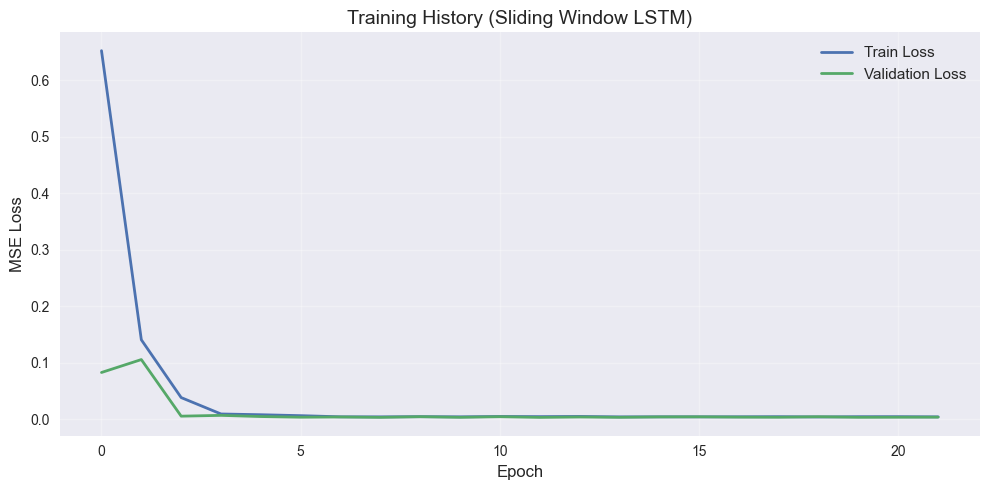

In [73]:
# 학습 및 검증 손실 곡선 시각화
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(history["train_loss"], label="Train Loss", linewidth=2)
ax.plot(history["val_loss"], label="Validation Loss", linewidth=2)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("MSE Loss", fontsize=12)
ax.set_title("Training History (Sliding Window LSTM)", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [74]:
# 검증 세트 예측 및 평가 지표 계산
model.eval()
from sklearn.metrics import r2_score
def predict_dataset(loader: DataLoader):
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds.append(preds_batch)
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

val_preds, val_targets = predict_dataset(val_loader)

# 평가 지표
val_mae = np.mean(np.abs(val_preds - val_targets))
val_rmse = np.sqrt(np.mean((val_preds - val_targets) ** 2))
val_mape = np.mean(np.abs((val_targets - val_preds) / val_targets)) * 100

print(f"검증 MAE: {val_mae:.4f}")
print(f"검증 RMSE: {val_rmse:.4f}")
print(f"검증 R2: {r2_score(val_targets, val_preds):.4f}")
print(f"검증 MAPE: {val_mape:.2f}%")

검증 MAE: 0.0471
검증 RMSE: 0.0631
검증 R2: 0.4005
검증 MAPE: 6.66%


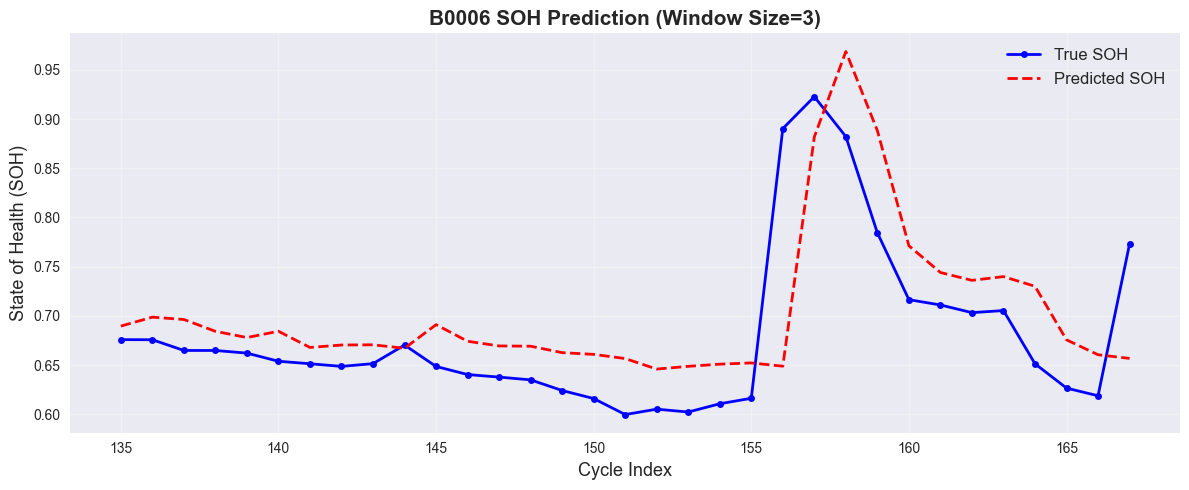

In [75]:
# 1. 예측 vs 실제 SOH 비교 시각화
prediction_cycles = np.arange(split_idx + WINDOW_SIZE, len(battery_meta))

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(prediction_cycles, val_targets, label="True SOH", marker="o", markersize=5, linewidth=2, color='blue')
ax.plot(prediction_cycles, val_preds, label="Predicted SOH", marker="x", markersize=5, linewidth=2, linestyle="--", color='red')
ax.set_xlabel("Cycle Index", fontsize=13)
ax.set_ylabel("State of Health (SOH)", fontsize=13)
ax.set_title(f"{battery_id} SOH Prediction (Window Size={WINDOW_SIZE})", fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

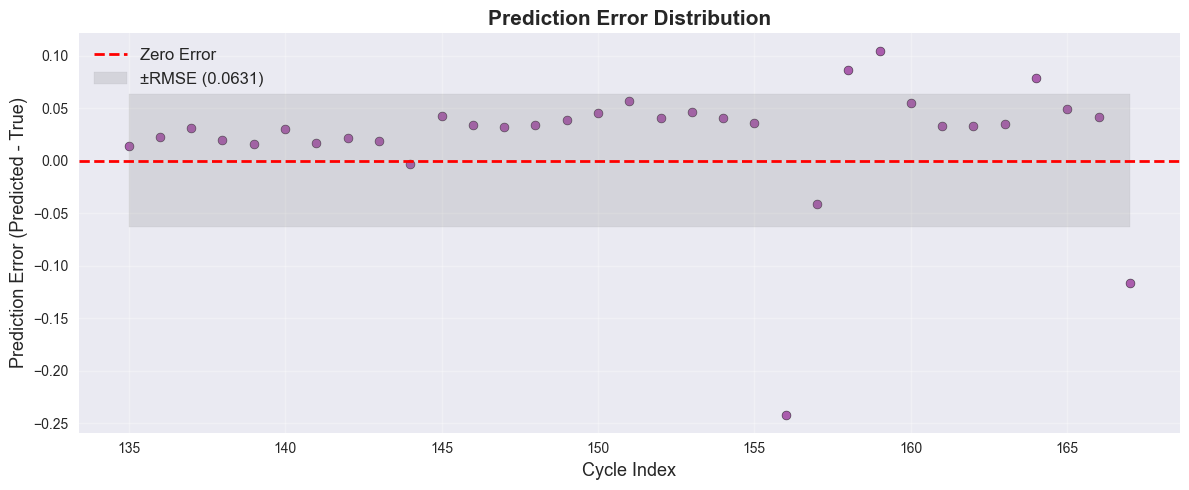

In [77]:
# 2. 예측 오차 분포 시각화
errors = val_preds - val_targets

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(prediction_cycles, errors, alpha=0.6, s=40, color='purple', edgecolors='black', linewidth=0.5)
ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.fill_between(prediction_cycles, -val_rmse, val_rmse, alpha=0.2, color='gray', label=f'±RMSE ({val_rmse:.4f})')
ax.set_xlabel("Cycle Index", fontsize=13)
ax.set_ylabel("Prediction Error (Predicted - True)", fontsize=13)
ax.set_title("Prediction Error Distribution", fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()